In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np

In [2]:
#get data

from data_utils import load_mnist

trX, teX, trY, teY = load_mnist(onehot=False)

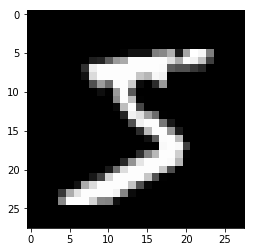

In [3]:
#view data

import matplotlib.pyplot as plt

plt.imshow(trX[0].reshape(28,28), cmap=plt.get_cmap('gray')) #need cmap thing or else is weird colour
plt.show()

In [4]:
#convert from numpy arrays to torch tensors

trX = torch.from_numpy(trX).float()
teX = torch.from_numpy(teX).float()
trY = torch.from_numpy(trY).long()
teY = torch.from_numpy(teY).long()

In [5]:
#create model

class Net(nn.Module):
    def __init__(self, output_size):
        super(Net, self).__init__()
        
        # to find the size (width x height) of a square image leaving a conv layer, the equation is:
        # Wo = ((Wi−F+2P)/S)+1, 
        # Wo is the width of the image output
        # Wi is the width of the image going in
        # F is the filter width (aka 'kernel size')
        # P is the padding
        # S is the stride
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=1, padding=2)
        # Wo = ((28-5+2*2)/1)+1 = 28
        self.bn1 = nn.BatchNorm2d(num_features=10)
        
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=1, padding=2)
        # Wo = ((14-5+2*2)/1)+1 = 14
        self.bn2 = nn.BatchNorm2d(num_features=20)
        
        self.fc = nn.Linear(7*7*20, output_size) #7x7 is size of the image, 20 is the number of channels
        
        self.logsoftmax = nn.LogSoftmax()
        
    def forward(self, x):
        #x = [32, 1, 28, 28]
        x = self.conv1(x) 
        #x= [32, 10, 28, 28]
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2) #pooling scales the image by 1/kernel_size, i.e. kernel size of 2 halves it
        x = self.conv2(x)
        #x = [32, 20, 14, 14]
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        #x = [32, 20, 7, 7]
        x = x.view(x.size(0), -1)
        #x = [32, 980], 980=20*7*7
        x = self.fc(x)
        #x = [32, 10]
        x = self.logsoftmax(x)
        return x

In [6]:
#create instance of Net class

net = Net(10)

In [7]:
#define some parameters

epochs = 10
batch_size = 32
learning_rate = 0.001
momentum = 0.9

In [8]:
#for plotting

plot_loss = []
plot_correct = []

In [9]:
#define loss and optimizer

criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

In [10]:
#training function

def train(model, criterion, optimizer, x, y):
    x = Variable(x, requires_grad=False)
    y = Variable(y, requires_grad=False)
    
    # Reset gradient
    optimizer.zero_grad()

    # Forward
    fx = model.forward(x)
    loss = criterion(fx, y)

    # Backward
    loss.backward()

    # Update parameters
    optimizer.step()

    return loss.data[0]

In [11]:
#make predictions

def predict(model, x, y):
    x = Variable(x, requires_grad=False)
    outputs = model(x)
    _, predicted = torch.max(outputs.data, 1) #for each output, get the predicted value (torch.max returns (index, value) tuple)
    correct = (predicted == y) #how many predicted values equal the labels
    return correct.sum() 

In [12]:
#run the training

# NOTE: 
#  should call net.train() when training and then net.eval() when testing,
#  this is so parameters of the batch_norm do not keep getting updated 
#  and also deals with dropout issues -> "activations at dropout layers need 
#  to be scaled during execution to account for the fact that certain units 
#  were deactivated during training"
#  see the links below:
#  https://discuss.pytorch.org/t/verifying-proper-usage-of-bach-norm-and-eval/293
#  https://discuss.pytorch.org/t/performance-highly-degraded-when-eval-is-activated-in-the-test-phase/3323/
#  https://discuss.pytorch.org/t/how-to-use-batch-normalization-in-testing-model/731/

num_examples = trX.shape[0]
num_batches = num_examples // batch_size #batches per epoch

#need to reshape to 4D to feed into convolutional neural net
trX = trX.view(-1, 1, 28, 28) #from [60000,784] to [60000, 1, 28, 28], the '1' is the number of colour channels
teX = teX.view(-1, 1, 28, 28)

for e in range(1, epochs+1):
    loss = 0.
    net.train()
    for k in range(num_batches):
        start, end = k * batch_size, (k + 1) * batch_size
        loss += train(net, criterion, optimizer, trX[start:end], trY[start:end])
    net.eval()
    correct = predict(net, teX, teY)
    plot_loss.append(loss/num_batches)
    plot_correct.append(correct/teX.shape[0]*100)
    print("Epoch %02d, loss = %f, accuracy = %.2f%%" % (e, loss / num_batches, correct/teX.shape[0]*100))

Epoch 01, loss = 0.311093, accuracy = 95.07%
Epoch 02, loss = 0.105091, accuracy = 96.75%
Epoch 03, loss = 0.077448, accuracy = 97.48%
Epoch 04, loss = 0.063634, accuracy = 97.98%
Epoch 05, loss = 0.055021, accuracy = 98.21%
Epoch 06, loss = 0.048984, accuracy = 98.49%
Epoch 07, loss = 0.044354, accuracy = 98.59%
Epoch 08, loss = 0.040617, accuracy = 98.68%
Epoch 09, loss = 0.037537, accuracy = 98.71%
Epoch 10, loss = 0.034895, accuracy = 98.76%


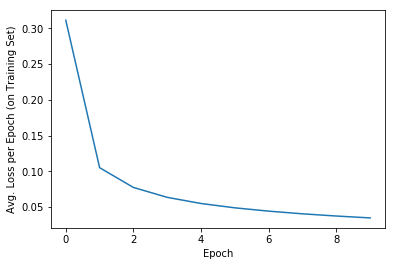

[0.3110925529294958, 0.10509075936134904, 0.07744777690945193, 0.06363439913480542, 0.055021259481351205, 0.04898350620749407, 0.04435358217635658, 0.04061718292523098, 0.03753680898915045, 0.034894552413412994]


In [17]:
plt.plot(plot_loss)
plt.xlabel('Epoch')
plt.ylabel('Avg. Loss per Epoch (on Training Set)')
plt.show()
print(plot_loss)

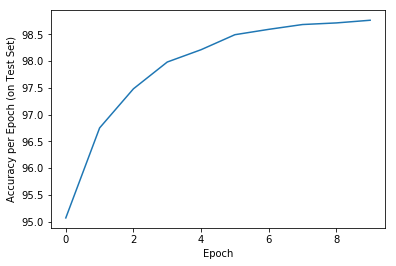

In [16]:
plt.plot(plot_correct)
plt.xlabel('Epoch')
plt.ylabel('Accuracy per Epoch (on Test Set)')
plt.show()